# Worm Mask Transfer Learning

References:
1. Bhattiprolu (segmentation resources)
2. https://github.com/qubvel/segmentation_models

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import backend as K

import segmentation_models as sm

Segmentation Models: using `keras` framework.


## Reading in the data
Input: worm_imgs is a tiff file of full worm images

Input: mask_imgs is a tiff file of those same images with the binary worm/no worm mask

In [2]:
worm_imgs = tifffile.imread('single_worms_set2_30im.tiff')
mask_imgs = tifffile.imread('masks_set2_30im.tiff')

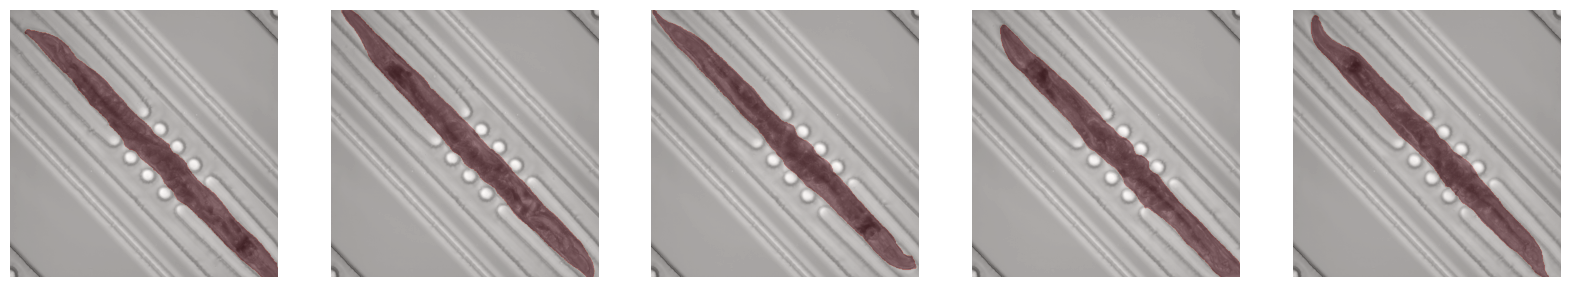

In [3]:
# Plotting a few images and masks to make sure they align
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images
    axs[i].imshow(worm_imgs[i], cmap='gray')

    # show mask overlay
    # cmap='Reds' makes the mask red
    # alpha sets the transparency level (0 is fully transparent, 1 is fully opaque)
    axs[i].imshow(mask_imgs[i], cmap='Reds', alpha=0.3)
    axs[i].axis('off')  # hide the axes

plt.show()

(-0.5, 511.5, 511.5, -0.5)

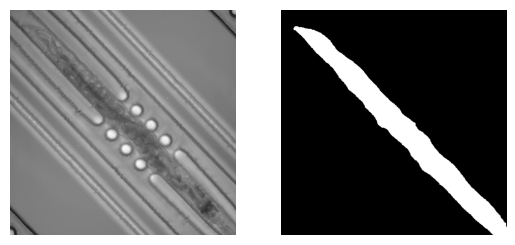

In [9]:
plt.subplot(1,2,1)
plt.imshow(worm_imgs[0], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_imgs[0], cmap='gray')
plt.axis('off')

In [ ]:
mask_patches = tf.image.extract_patches(images=mask_imgs[...,np.newaxis],
                           sizes=[1, 128, 128, 1],
                           strides=[1,64, 64, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches.shape
# returns TensorShape([1, 7, 7, 16384])

mask_patches_reshaped = np.array(tf.reshape(mask_patches, [-1, 128, 128]))

mask_patches_reshaped.shape

(1470, 128, 128)

In [ ]:
im_patches = tf.image.extract_patches(images=worm_imgs[...,np.newaxis],
                           sizes=[1, 128, 128, 1],
                           strides=[1,64, 64, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

im_patches.shape
# returns TensorShape([1, 7, 7, 16384])

im_patches_reshaped = np.array(tf.reshape(im_patches, [-1, 128, 128]))

im_patches_reshaped.shape

(1470, 128, 128)

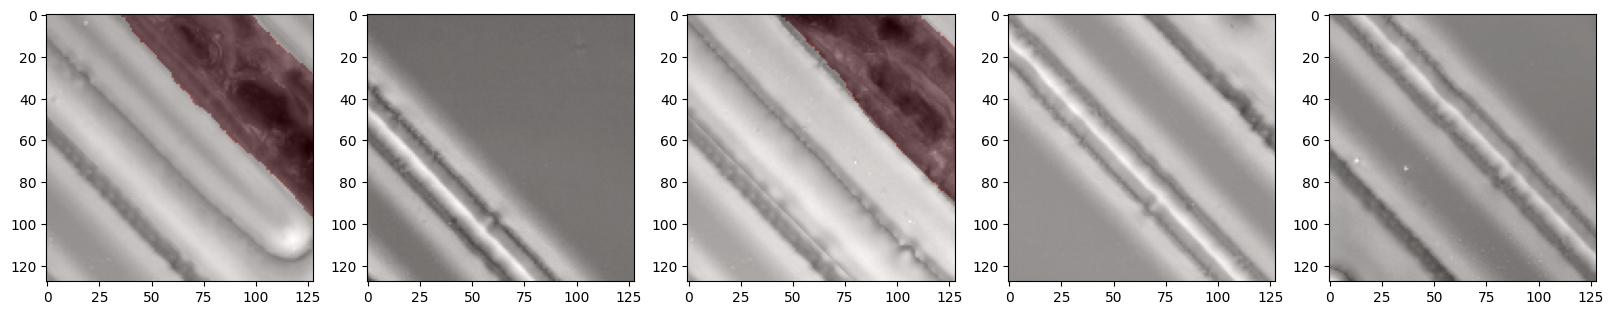

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [ ]:
pix_count_thresh = 128*128*0.05

accepted_patch_nums = [i for i,m in enumerate(mask_patches_reshaped) if np.sum(m)>pix_count_thresh]
accepted_patch_nums

mask_patches_reshaped = mask_patches_reshaped[accepted_patch_nums]
im_patches_reshaped = im_patches_reshaped[accepted_patch_nums]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(im_patches_reshaped, mask_patches_reshaped, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(462, 128, 128)
(155, 128, 128)


In [ ]:
X_train = np.stack((X_train,)*3, axis=-1)
y_train = np.stack((y_train,)*3, axis=-1)

print(X_train.shape)
print(y_train.shape)

(462, 128, 128, 3)
(462, 128, 128, 3)


In [ ]:
X_test = np.stack((X_test,)*3, axis=-1)
y_test = np.stack((y_test,)*3, axis=-1)
print(X_test.shape)
print(y_test.shape)

(155, 128, 128, 3)
(155, 128, 128, 3)


In [ ]:
#New generator with rotation where interpolation that comes with rotation are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
from keras.preprocessing.image import ImageDataGenerator



img_data_gen_args = dict(rotation_range=0,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')



mask_data_gen_args = dict(rotation_range=0,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

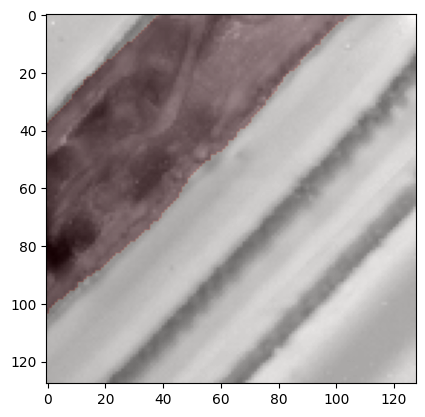

In [ ]:
x = image_generator.next()
y = mask_generator.next()

i = 0
plt.imshow(x[i,...,0],'gray')
plt.imshow(y[i,...,0],'Reds',alpha = 0.2)

## Training

In [ ]:
# define the model
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

checkpoint = ModelCheckpoint('best_backresnet34_weightimagenet_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // 16,
                    validation_steps=len(X_train) // 16,
                    epochs=40,
                    callbacks=[checkpoint])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

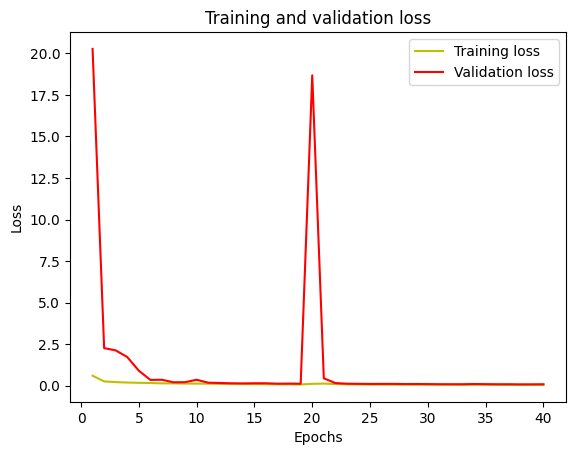

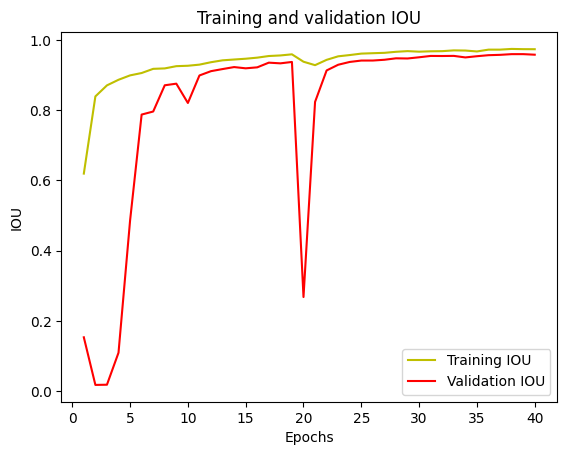

5/5 [==============================] - 1s 49ms/step
IoU socre is:  0.9601226252036048


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 24ms/step


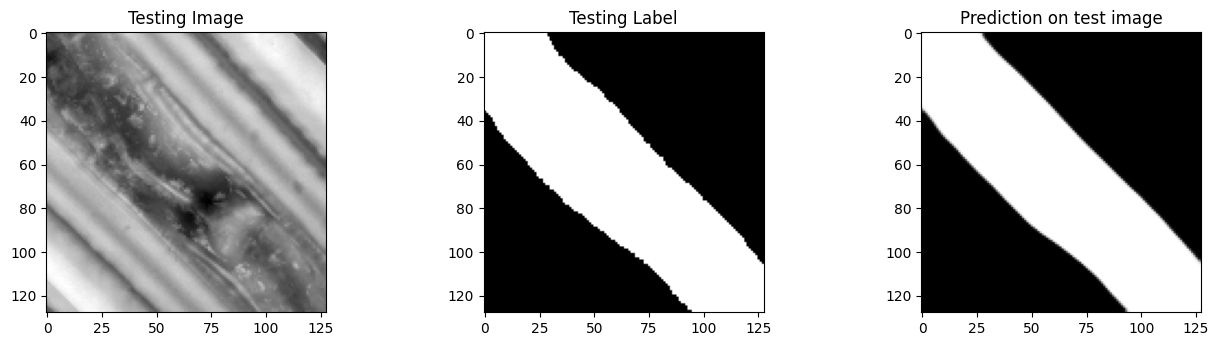

In [ ]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
# define the model
BACKBONE = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

checkpoint = ModelCheckpoint('best_backvgg16_weightimagenet_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // 16,
                    validation_steps=len(X_train) // 16,
                    epochs=40,
                    callbacks=[checkpoint])


58889256/58889256 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                           

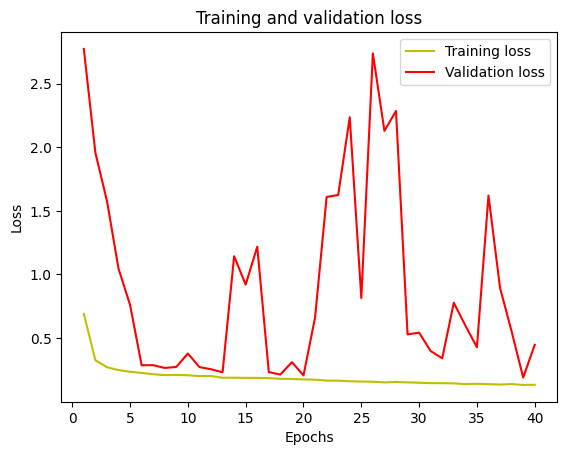

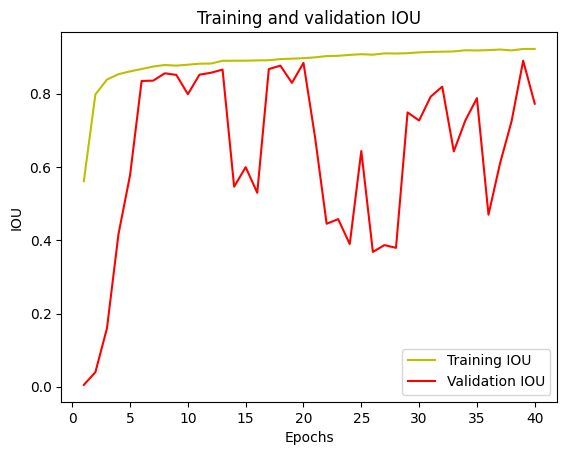

5/5 [==============================] - 1s 71ms/step
IoU socre is:  0.7717530459135928


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 1s 989ms/step


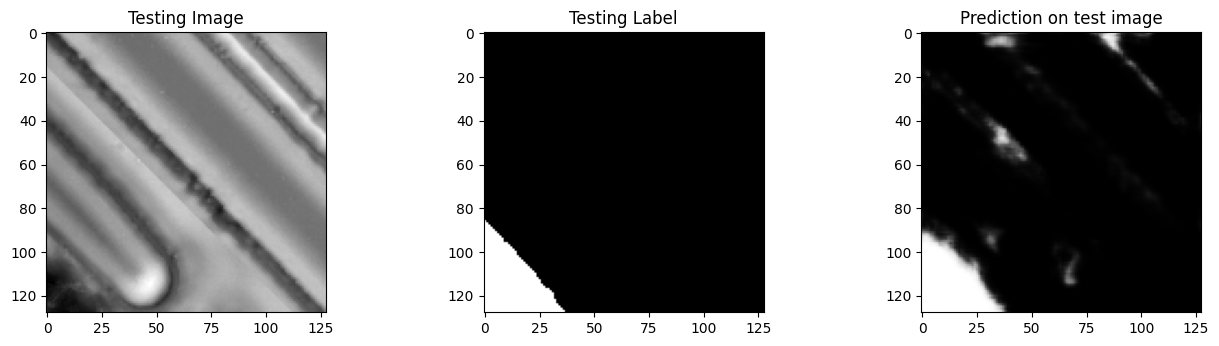

In [ ]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

checkpoint = ModelCheckpoint('best_backresnet18_weightimagenet_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // 16,
                    validation_steps=len(X_train) // 16,
                    epochs=40,
                    callbacks=[checkpoint])

44920640/44920640 [==============================] - 2s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                       

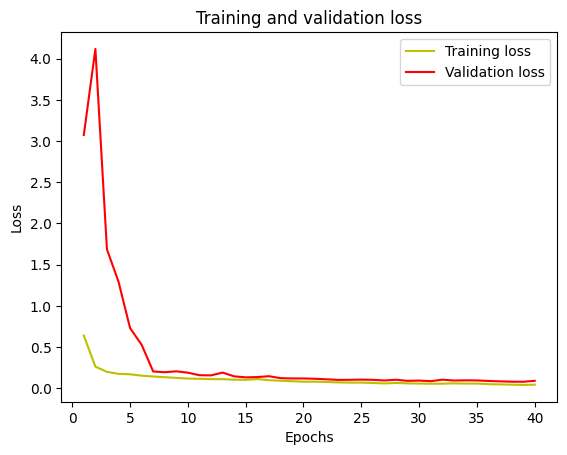

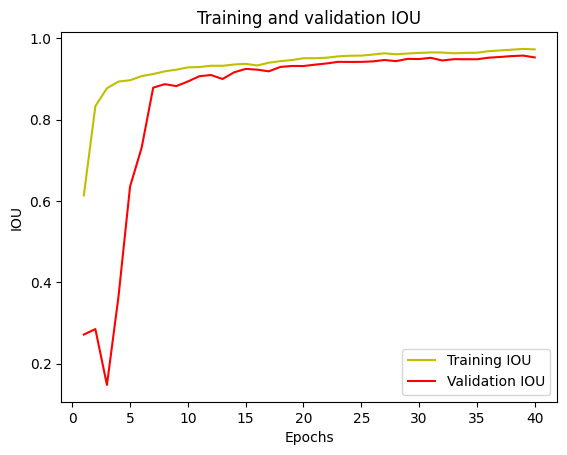

5/5 [==============================] - 1s 44ms/step
IoU socre is:  0.9560171411490939


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 86ms/step


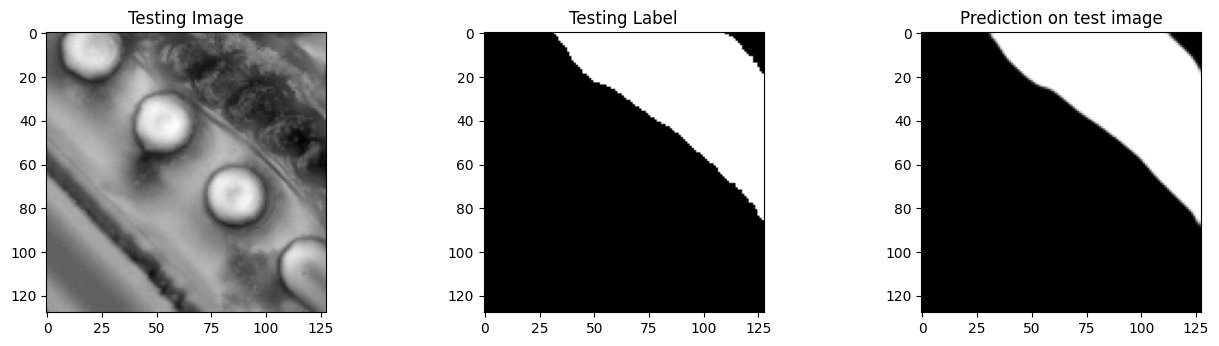

In [ ]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
# define the model
BACKBONE = 'inceptionv3'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

checkpoint = ModelCheckpoint('best_backinceptionv3_weightimagenet_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // 16,
                    validation_steps=len(X_train) // 16,
                    epochs=40,
                    callbacks=[checkpoint])

87910968/87910968 [==============================] - 6s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                

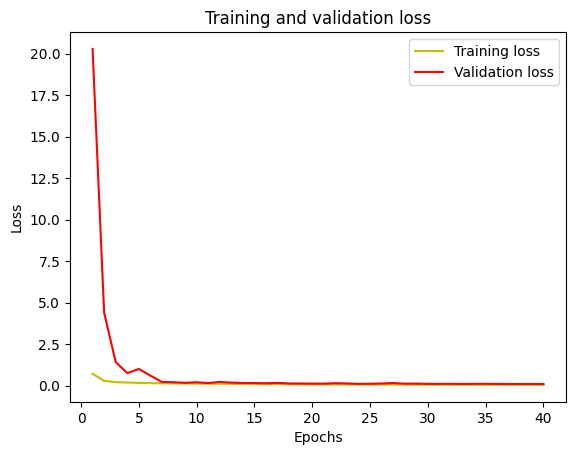

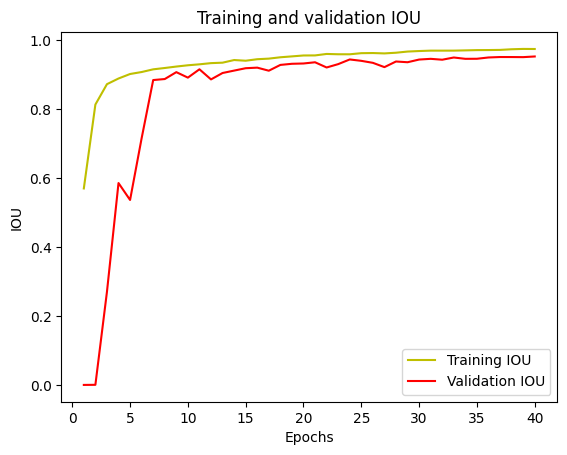

5/5 [==============================] - 2s 73ms/step
IoU socre is:  0.9564046619728133


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 32ms/step


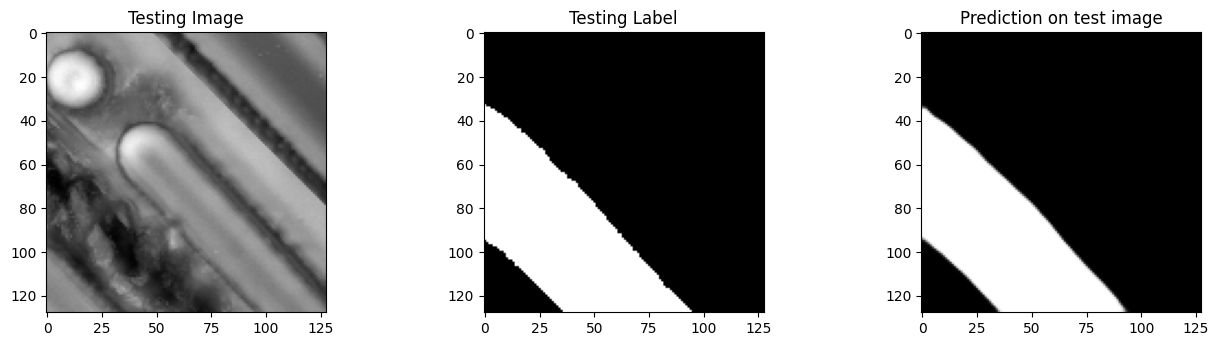

In [ ]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [14]:
# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.load_weights('best_backresnet18_weightimagenet_.h5')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

                                                                                                  
 stage2_unit1_bn1 (BatchNormali  (None, None, None,   256        ['add_9[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage2_unit1_relu1 (Activation  (None, None, None,   0          ['stage2_unit1_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage2_unit1_relu1[0][0]']     
 2D)                            64)                                                               
                                                                                                  
 stage2_un

                                256)                                                              
                                                                                                  
 add_12 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_12[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
          

 stage4_unit2_conv2 (Conv2D)    (None, None, None,   2359296     ['zero_padding2d_35[0][0]']      
                                512)                                                              
                                                                                                  
 add_15 (Add)                   (None, None, None,   0           ['stage4_unit2_conv2[0][0]',     
                                512)                              'add_14[0][0]']                 
                                                                                                  
 bn1 (BatchNormalization)       (None, None, None,   2048        ['add_15[0][0]']                 
                                512)                                                              
                                                                                                  
 relu1 (Activation)             (None, None, None,   0           ['bn1[0][0]']                    
          

                                                                                                  
 decoder_stage2b_relu (Activati  (None, None, None,   0          ['decoder_stage2b_bn[0][0]']     
 on)                            64)                                                               
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, None, None,   0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     64)                                                               
                                                                                                  
 decoder_stage3_concat (Concate  (None, None, None,   0          ['decoder_stage3_upsampling[0][0]
 nate)                          128)                             ',                               
                                                                  'relu0[0][0]']                  
          

In [12]:
plt.subplot(1,2,1)
plt.imshow(worm_imgs[0], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(worm_imgs[:5], cmap='gray')
plt.axis('off')

In [18]:
worm_ims_expand = np.stack((worm_imgs[:10],)*3, axis=-1)
worm_ims_expand.shape

(10, 512, 512, 3)

1/1 [==============================] - 0s 208ms/step


(-0.5, 511.5, 511.5, -0.5)

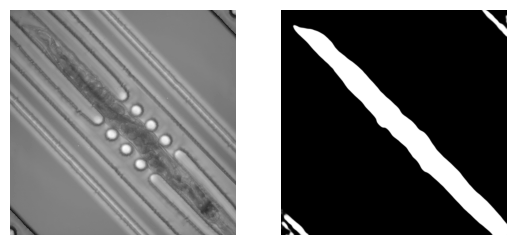

In [20]:

in_im = worm_ims_expand[:1]
out_im = model.predict(in_im)

plt.subplot(1,2,1)
plt.imshow(in_im[0,...,0], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(out_im[0,...,0], cmap='gray')
plt.axis('off')